# Exploratory Analysis of Spatial Data

## Imports

In [1]:
import warnings
import prince
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import kstest

from pysal.lib import weights
from pysal.explore import esda

from esda.moran import Moran 
from sklearn.metrics import mean_squared_error as mse

from statsmodels.graphics.gofplots import qqplot
from pysal.model import spreg

warnings.filterwarnings('ignore')

d:\Anaconda\envs\ETE22\lib\site-packages\spaghetti\network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


### Load spatial data 
Load the Administrative Map of Portugal - Carta administrativa oficial de portugal (CAOP) from an external source of information - DGTerritório https://www.dgterritorio.gov.pt/cartografia/cartografia-tematica/caop

In [2]:
df_pt = gpd.read_file('Cont_AAD_CAOP2021/Cont_AAD_CAOP2021.shp')

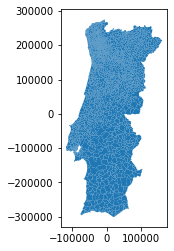

In [3]:
df_pt.plot()
plt.show()

In [4]:
df_pt.shape

(3223, 9)

In [5]:
df_pt.head()

,Dicofre,Freguesia,Concelho,Distrito,TAA,Area_T_ha,Area_EA_ha,Des_Simpli,geometry
0,081504,Sagres,Vila do Bispo,Faro,ÁREA SECUNDÁRIA,3436.93,0.04,Sagres,"POLYGON ((-69674.530 -294276.294, -69681.011 -..."
1,081504,Sagres,Vila do Bispo,Faro,ÁREA SECUNDÁRIA,3436.93,0.17,Sagres,"POLYGON ((-69645.821 -294240.694, -69657.401 -..."
2,081504,Sagres,Vila do Bispo,Faro,ÁREA SECUNDÁRIA,3436.93,0.20,Sagres,"POLYGON ((-69720.371 -294162.995, -69715.271 -..."
3,081504,Sagres,Vila do Bispo,Faro,ÁREA SECUNDÁRIA,3436.93,0.09,Sagres,"POLYGON ((-70031.961 -294143.877, -70041.691 -..."
4,081504,Sagres,Vila do Bispo,Faro,ÁREA SECUNDÁRIA,3436.93,0.39,Sagres,"POLYGON ((-69800.002 -294108.296, -69796.762 -..."


### Manipulate spatial polygons 
Aggregate Polygons - from parishes to municipalities: from the unique code of each parish (DICOFRE) it is possible to aggregate any administrative unit of a higher order - (https://dados.gov.pt/pt/datasets/r/ec6ef805-c278-4b4d-ba9b-3116264f68b4). 

(the *.DBF file provides a unique 6 digit text string for each polygons *.SHP)

In [6]:
#criar uma nova coluna com os 4 primeiros dígitos correspondentes aos respetivos códigos municipais
df_pt['Dicomun'] = df_pt['Dicofre'].astype(str).str[:4].astype(int)
df_pt.head()

,Dicofre,Freguesia,Concelho,Distrito,TAA,Area_T_ha,Area_EA_ha,Des_Simpli,geometry,Dicomun
0,081504,Sagres,Vila do Bispo,Faro,ÁREA SECUNDÁRIA,3436.93,0.04,Sagres,"POLYGON ((-69674.530 -294276.294, -69681.011 -...",815
1,081504,Sagres,Vila do Bispo,Faro,ÁREA SECUNDÁRIA,3436.93,0.17,Sagres,"POLYGON ((-69645.821 -294240.694, -69657.401 -...",815
2,081504,Sagres,Vila do Bispo,Faro,ÁREA SECUNDÁRIA,3436.93,0.20,Sagres,"POLYGON ((-69720.371 -294162.995, -69715.271 -...",815
3,081504,Sagres,Vila do Bispo,Faro,ÁREA SECUNDÁRIA,3436.93,0.09,Sagres,"POLYGON ((-70031.961 -294143.877, -70041.691 -...",815
4,081504,Sagres,Vila do Bispo,Faro,ÁREA SECUNDÁRIA,3436.93,0.39,Sagres,"POLYGON ((-69800.002 -294108.296, -69796.762 -...",815


In [7]:
df_pt_mun = df_pt.dissolve(by=['Dicomun', 'Concelho', 'Distrito'] )

In [8]:
df_pt_mun.head()

,,,geometry,Dicofre,Freguesia,TAA,Area_T_ha,Area_EA_ha,Des_Simpli
Dicomun,Concelho,Distrito,,,,,,,
101,Águeda,Aveiro,"POLYGON ((-25647.507 93242.339, -25739.783 931...",010127,União das freguesias do Préstimo e Macieira de...,ÁREA PRINCIPAL,4172.64,4172.64,Préstimo e Macieira de Alcoba
102,Albergaria-a-Velha,Aveiro,"POLYGON ((-29040.418 108964.754, -29041.338 10...",010202,Alquerubim,ÁREA PRINCIPAL,1535.86,1535.86,Alquerubim
103,Anadia,Aveiro,"POLYGON ((-17967.760 83828.847, -17911.070 838...",010312,Vila Nova de Monsarros,ÁREA PRINCIPAL,2372.04,2372.04,Vila Nova de Monsarros
104,Arouca,Aveiro,"POLYGON ((-14528.269 134014.425, -14662.068 13...",010413,Mansores,ÁREA PRINCIPAL,1407.54,1407.54,Mansores
105,Aveiro,Aveiro,"POLYGON ((-34573.847 100271.486, -34730.113 10...",010513,Santa Joana,ÁREA PRINCIPAL,584.55,584.55,Santa Joana


In [9]:
df_pt_mun = df_pt_mun.reset_index()
df_pt_mun.head()

,Dicomun,Concelho,Distrito,geometry,Dicofre,Freguesia,TAA,Area_T_ha,Area_EA_ha,Des_Simpli
0,101,Águeda,Aveiro,"POLYGON ((-25647.507 93242.339, -25739.783 931...",010127,União das freguesias do Préstimo e Macieira de...,ÁREA PRINCIPAL,4172.64,4172.64,Préstimo e Macieira de Alcoba
1,102,Albergaria-a-Velha,Aveiro,"POLYGON ((-29040.418 108964.754, -29041.338 10...",010202,Alquerubim,ÁREA PRINCIPAL,1535.86,1535.86,Alquerubim
2,103,Anadia,Aveiro,"POLYGON ((-17967.760 83828.847, -17911.070 838...",010312,Vila Nova de Monsarros,ÁREA PRINCIPAL,2372.04,2372.04,Vila Nova de Monsarros
3,104,Arouca,Aveiro,"POLYGON ((-14528.269 134014.425, -14662.068 13...",010413,Mansores,ÁREA PRINCIPAL,1407.54,1407.54,Mansores
4,105,Aveiro,Aveiro,"POLYGON ((-34573.847 100271.486, -34730.113 10...",010513,Santa Joana,ÁREA PRINCIPAL,584.55,584.55,Santa Joana


In [10]:
df_pt_mun.columns

Index(['Dicomun', 'Concelho', 'Distrito', 'geometry', 'Dicofre', 'Freguesia',
       'TAA', 'Area_T_ha', 'Area_EA_ha', 'Des_Simpli'],
      dtype='object')

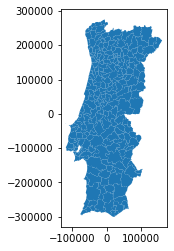

In [11]:
df_pt_mun.plot()
plt.show()

### Import external data (new variables)

#### Codes

My focus in this paper is the study of the NUTS III regions around Viseu:
1. Viseu Dão Lafões
2. Beiras e Serra da Estrela
3. Douro
4. Tâmega e Sousa
5. Área Metropolitana do Porto
6. Região de Coimbra
7. Região de Aveiro

To do this we need to merge the first dataframe with another dataframe that contains the NUTS III codes

In [12]:
df_nuts_code = pd.read_excel("codes_information.xlsx", sheet_name="codificação")
df_nuts_code.head()

,DICO,NUTSI_DSG,NUTSI_COD,NUTSII_DSG,NUTSII_COD,NUTSIII_DSG,NUTSIII_COD,DISTRITO_ILHA_DSG,CONCELHO_DSG,AREA_2021_ha,AREA_2021_km2,PERIM_km,ALTITUDE_MAX_m,ALTITUDE_MIN_m
0,201,Continente,1,Alentejo,18,Baixo Alentejo,184,Beja,Aljustrel,45847.41,458.47,112,258,63
1,202,Continente,1,Alentejo,18,Baixo Alentejo,184,Beja,Almodôvar,77788.03,777.88,199,577,150
2,203,Continente,1,Alentejo,18,Baixo Alentejo,184,Beja,Alvito,26485.32,264.85,81,315,100
3,204,Continente,1,Alentejo,18,Baixo Alentejo,184,Beja,Barrancos,16841.73,168.42,106,412,125
4,205,Continente,1,Alentejo,18,Baixo Alentejo,184,Beja,Beja,114647.55,1146.48,208,284,25


In [13]:
df_nuts_code.columns

Index(['DICO', 'NUTSI_DSG', 'NUTSI_COD', 'NUTSII_DSG', 'NUTSII_COD',
       'NUTSIII_DSG', 'NUTSIII_COD', 'DISTRITO_ILHA_DSG', 'CONCELHO_DSG',
       'AREA_2021_ha', 'AREA_2021_km2', 'PERIM_km', 'ALTITUDE_MAX_m',
       'ALTITUDE_MIN_m'],
      dtype='object')

In [14]:
nuts_3_codes = ["16G", "16J", "11D", "11C", "11A", "16E", "16D"]

In [15]:
df_nuts = df_nuts_code[df_nuts_code["NUTSIII_COD"].isin(nuts_3_codes)]
df_nuts

,DICO,NUTSI_DSG,NUTSI_COD,NUTSII_DSG,NUTSII_COD,NUTSIII_DSG,NUTSIII_COD,DISTRITO_ILHA_DSG,CONCELHO_DSG,AREA_2021_ha,AREA_2021_km2,PERIM_km,ALTITUDE_MAX_m,ALTITUDE_MIN_m
74,101,Continente,1,Centro,16,Região de Aveiro,16D,Aveiro,Águeda,33527.44,335.27,105,762,4
75,102,Continente,1,Centro,16,Região de Aveiro,16D,Aveiro,Albergaria-a-Velha,15882.50,158.82,82,425,0
76,103,Continente,1,Centro,16,Região de Aveiro,16D,Aveiro,Anadia,21663.48,216.63,75,525,13
77,105,Continente,1,Centro,16,Região de Aveiro,16D,Aveiro,Aveiro,19757.57,197.58,77,78,0
78,108,Continente,1,Centro,16,Região de Aveiro,16D,Aveiro,Estarreja,10817.33,108.17,68,130,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,1813,Continente,1,Norte,11,Tâmega e Sousa,11C,Viseu,Resende,12334.93,123.35,58,1218,50
274,1815,Continente,1,Norte,11,Douro,11D,Viseu,São João da Pesqueira,26610.85,266.11,100,994,75
275,1818,Continente,1,Norte,11,Douro,11D,Viseu,Sernancelhe,22861.22,228.61,99,964,475
276,1819,Continente,1,Norte,11,Douro,11D,Viseu,Tabuaço,13385.67,133.86,70,985,75


In [16]:
df_nuts["NUTSIII_COD"].unique()

array(['16D', '16E', '16J', '16G', '11A', '11C', '11D'], dtype=object)

In [17]:
df_nuts["NUTSIII_DSG"].unique()

array(['Região de Aveiro', 'Região de Coimbra',
       'Beiras e Serra da Estrela', 'Viseu Dão Lafões',
       'Área Metropolitana do Porto', 'Tâmega e Sousa', 'Douro'],
      dtype=object)

In [18]:
df_nuts['Dicomun'] = df_nuts['DICO'].astype(str).str[:4].astype(int)
df_nuts.head()

,DICO,NUTSI_DSG,NUTSI_COD,NUTSII_DSG,NUTSII_COD,NUTSIII_DSG,NUTSIII_COD,DISTRITO_ILHA_DSG,CONCELHO_DSG,AREA_2021_ha,AREA_2021_km2,PERIM_km,ALTITUDE_MAX_m,ALTITUDE_MIN_m,Dicomun
74,101,Continente,1,Centro,16,Região de Aveiro,16D,Aveiro,Águeda,33527.44,335.27,105,762,4,101
75,102,Continente,1,Centro,16,Região de Aveiro,16D,Aveiro,Albergaria-a-Velha,15882.50,158.82,82,425,0,102
76,103,Continente,1,Centro,16,Região de Aveiro,16D,Aveiro,Anadia,21663.48,216.63,75,525,13,103
77,105,Continente,1,Centro,16,Região de Aveiro,16D,Aveiro,Aveiro,19757.57,197.58,77,78,0,105
78,108,Continente,1,Centro,16,Região de Aveiro,16D,Aveiro,Estarreja,10817.33,108.17,68,130,0,108


In [19]:
df_pt_mun_nuts = df_pt_mun.merge(df_nuts)
df_pt_mun_nuts.shape

(106, 24)

In [20]:
df_pt_mun_nuts.columns

Index(['Dicomun', 'Concelho', 'Distrito', 'geometry', 'Dicofre', 'Freguesia',
       'TAA', 'Area_T_ha', 'Area_EA_ha', 'Des_Simpli', 'DICO', 'NUTSI_DSG',
       'NUTSI_COD', 'NUTSII_DSG', 'NUTSII_COD', 'NUTSIII_DSG', 'NUTSIII_COD',
       'DISTRITO_ILHA_DSG', 'CONCELHO_DSG', 'AREA_2021_ha', 'AREA_2021_km2',
       'PERIM_km', 'ALTITUDE_MAX_m', 'ALTITUDE_MIN_m'],
      dtype='object')

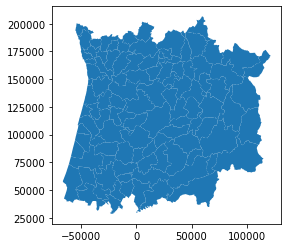

In [21]:
df_pt_mun_nuts.plot()
plt.show()

#### Import covid dataset

Importing socioeconomic and territorial data calculated from the BGRI, the resulting factors and the COVID 19 cases 

In [22]:
df_covid = pd.read_table('dataset_BGRI_COVID.csv', sep = ";", encoding='latin1')

In [23]:
df_covid.head()

,GEOID,DESIGNACAO,IVolumetria,vagos_perc,IMedia_edif,aloj_habitual_perc,dimensao_aloj,aloj_por_familia,arrendamento_perc,ind_envelhecimento,...,divisoes_n,FAC1_3,FAC2_3,FAC3_3,FAC4_3,FAC5_3,CLU6_1,populacao,COVIDConfirmadosAcum,COVID_confirmados_10mil_hab
0,101,Águeda,1.73,0.13,36.10,0.76,144.41,1.31,0.08,101.84,...,3.39,1.08,-1.33,-1.13,0.29,-0.43,1,47729,202,42.32
1,102,Albergaria-a-Velha,1.71,0.14,38.21,0.74,136.91,1.33,0.07,86.86,...,3.38,1.00,-1.06,-0.97,0.15,0.07,1,25252,153,60.59
2,103,Anadia,1.63,0.15,37.80,0.72,148.89,1.39,0.06,133.94,...,3.39,0.70,-0.61,-1.64,0.60,0.21,1,29150,111,38.08
3,104,Arouca,1.65,0.09,34.21,0.69,128.59,1.44,0.06,83.43,...,3.32,0.68,-1.61,-0.54,-0.96,-0.94,2,22359,272,121.65
4,105,Aveiro,2.00,0.12,35.72,0.75,134.47,1.31,0.17,84.75,...,3.40,1.45,1.19,-0.38,0.27,-0.75,3,78450,626,79.80


In [24]:
df_covid.columns

Index(['GEOID', 'DESIGNACAO', 'IVolumetria', 'vagos_perc', 'IMedia_edif',
       'aloj_habitual_perc', 'dimensao_aloj', 'aloj_por_familia',
       'arrendamento_perc', 'ind_envelhecimento', 'ind_qualificacoes',
       'ind_migraçao', 'primario_perc', 'secundario_perc', 'terciario_perc',
       'divisoes_n', 'FAC1_3', 'FAC2_3', 'FAC3_3', 'FAC4_3', 'FAC5_3',
       'CLU6_1', 'populacao', 'COVIDConfirmadosAcum',
       'COVID_confirmados_10mil_hab'],
      dtype='object')

In [25]:
df_covid.dtypes

GEOID                            int64
DESIGNACAO                      object
IVolumetria                    float64
vagos_perc                     float64
IMedia_edif                    float64
aloj_habitual_perc             float64
dimensao_aloj                  float64
aloj_por_familia               float64
arrendamento_perc              float64
ind_envelhecimento             float64
ind_qualificacoes              float64
ind_migraçao                   float64
primario_perc                  float64
secundario_perc                float64
terciario_perc                 float64
divisoes_n                     float64
FAC1_3                         float64
FAC2_3                         float64
FAC3_3                         float64
FAC4_3                         float64
FAC5_3                         float64
CLU6_1                           int64
populacao                        int64
COVIDConfirmadosAcum             int64
COVID_confirmados_10mil_hab    float64
dtype: object

In [26]:
df = df_pt_mun_nuts.merge(df_covid, right_on = "GEOID", left_on = "Dicomun")

In [27]:
df.columns

Index(['Dicomun', 'Concelho', 'Distrito', 'geometry', 'Dicofre', 'Freguesia',
       'TAA', 'Area_T_ha', 'Area_EA_ha', 'Des_Simpli', 'DICO', 'NUTSI_DSG',
       'NUTSI_COD', 'NUTSII_DSG', 'NUTSII_COD', 'NUTSIII_DSG', 'NUTSIII_COD',
       'DISTRITO_ILHA_DSG', 'CONCELHO_DSG', 'AREA_2021_ha', 'AREA_2021_km2',
       'PERIM_km', 'ALTITUDE_MAX_m', 'ALTITUDE_MIN_m', 'GEOID', 'DESIGNACAO',
       'IVolumetria', 'vagos_perc', 'IMedia_edif', 'aloj_habitual_perc',
       'dimensao_aloj', 'aloj_por_familia', 'arrendamento_perc',
       'ind_envelhecimento', 'ind_qualificacoes', 'ind_migraçao',
       'primario_perc', 'secundario_perc', 'terciario_perc', 'divisoes_n',
       'FAC1_3', 'FAC2_3', 'FAC3_3', 'FAC4_3', 'FAC5_3', 'CLU6_1', 'populacao',
       'COVIDConfirmadosAcum', 'COVID_confirmados_10mil_hab'],
      dtype='object')

In [28]:
df

,Dicomun,Concelho,Distrito,geometry,Dicofre,Freguesia,TAA,Area_T_ha,Area_EA_ha,Des_Simpli,...,divisoes_n,FAC1_3,FAC2_3,FAC3_3,FAC4_3,FAC5_3,CLU6_1,populacao,COVIDConfirmadosAcum,COVID_confirmados_10mil_hab
0,101,Águeda,Aveiro,"POLYGON ((-25647.507 93242.339, -25739.783 931...",010127,União das freguesias do Préstimo e Macieira de...,ÁREA PRINCIPAL,4172.64,4172.64,Préstimo e Macieira de Alcoba,...,3.39,1.08,-1.33,-1.13,0.29,-0.43,1,47729,202,42.32
1,102,Albergaria-a-Velha,Aveiro,"POLYGON ((-29040.418 108964.754, -29041.338 10...",010202,Alquerubim,ÁREA PRINCIPAL,1535.86,1535.86,Alquerubim,...,3.38,1.00,-1.06,-0.97,0.15,0.07,1,25252,153,60.59
2,103,Anadia,Aveiro,"POLYGON ((-17967.760 83828.847, -17911.070 838...",010312,Vila Nova de Monsarros,ÁREA PRINCIPAL,2372.04,2372.04,Vila Nova de Monsarros,...,3.39,0.70,-0.61,-1.64,0.60,0.21,1,29150,111,38.08
3,104,Arouca,Aveiro,"POLYGON ((-14528.269 134014.425, -14662.068 13...",010413,Mansores,ÁREA PRINCIPAL,1407.54,1407.54,Mansores,...,3.32,0.68,-1.61,-0.54,-0.96,-0.94,2,22359,272,121.65
4,105,Aveiro,Aveiro,"POLYGON ((-34573.847 100271.486, -34730.113 10...",010513,Santa Joana,ÁREA PRINCIPAL,584.55,584.55,Santa Joana,...,3.40,1.45,1.19,-0.38,0.27,-0.75,3,78450,626,79.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,1820,Tarouca,Viseu,"POLYGON ((34344.274 148409.357, 34348.413 1484...",182013,União das freguesias de Tarouca e Dálvares,ÁREA PRINCIPAL,2191.66,2191.66,Tarouca e Dálvares,...,3.37,-1.04,-0.27,-0.61,1.18,1.83,1,8048,7,8.70
102,1821,Tondela,Viseu,"POLYGON ((2508.491 88461.830, 2479.582 88460.4...",182107,Ferreirós do Dão,ÁREA PRINCIPAL,828.64,828.64,Ferreirós do Dão,...,3.39,-0.19,-0.79,-0.18,0.37,-0.04,4,28946,47,16.24
103,1822,Vila Nova de Paiva,Viseu,"POLYGON ((34808.673 122308.620, 34811.563 1222...",182204,Queiriga,ÁREA PRINCIPAL,3193.74,3193.74,Queiriga,...,3.35,-1.23,-0.02,-0.03,0.56,-0.61,4,5176,11,21.25
104,1823,Viseu,Viseu,"POLYGON ((19440.461 101634.577, 19373.844 1015...",182327,São João de Lourosa,ÁREA PRINCIPAL,2600.41,2600.41,São João de Lourosa,...,3.38,0.74,1.29,-0.35,0.58,-0.86,3,99274,363,36.57


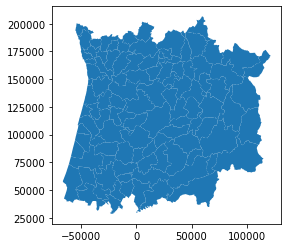

In [29]:
df.plot()
plt.show()

### Weights Matrices and Neighborhoods  
A way to represent graphs in geographic data science and spatial statistics, representing  relationships between spatial  observational units

#### 1. Contiguity Weights

In [30]:
w_queen = weights.contiguity.Queen.from_dataframe(df)

In [31]:
w_queen.weights

{0: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 1: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 2: [1.0, 1.0, 1.0, 1.0, 1.0],
 3: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 4: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 5: [1.0, 1.0, 1.0, 1.0, 1.0],
 6: [1.0, 1.0, 1.0],
 7: [1.0, 1.0, 1.0, 1.0],
 8: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 9: [1.0, 1.0],
 10: [1.0, 1.0, 1.0, 1.0, 1.0],
 11: [1.0, 1.0, 1.0, 1.0],
 12: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 13: [1.0, 1.0, 1.0, 1.0, 1.0],
 14: [1.0, 1.0, 1.0, 1.0, 1.0],
 15: [1.0, 1.0],
 16: [1.0, 1.0, 1.0, 1.0, 1.0],
 17: [1.0, 1.0, 1.0, 1.0, 1.0],
 18: [1.0, 1.0, 1.0, 1.0, 1.0],
 19: [1.0, 1.0],
 20: [1.0, 1.0, 1.0, 1.0, 1.0],
 21: [1.0, 1.0, 1.0],
 22: [1.0, 1.0, 1.0],
 23: [1.0, 1.0, 1.0, 1.0],
 24: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 25: [1.0, 1.0, 1.0, 1.0],
 26: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 27: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 28: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 29: [1.0, 1.0, 1.0, 1.0, 1.0],
 30: [1.0, 1.0, 1.0]

In [32]:
w_queen.set_transform('R')

In [33]:
w_queen.weights

{0: [0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111,
  0.1111111111111111],
 1: [0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666],
 2: [0.2, 0.2, 0.2, 0.2, 0.2],
 3: [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
 4: [0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666],
 5: [0.2, 0.2, 0.2, 0.2, 0.2],
 6: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
 7: [0.25, 0.25, 0.25, 0.25],
 8: [0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285,
  0.14285714285714285],
 9: [0.5, 0.5],
 10: [0.2, 0.2, 0.2, 0.2, 0.2],
 11: [0.25, 0.25, 0.25, 0.25],
 12: [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.

In [34]:
w_queen.cardinalities

{0: 9,
 1: 6,
 2: 5,
 3: 8,
 4: 6,
 5: 5,
 6: 3,
 7: 4,
 8: 7,
 9: 2,
 10: 5,
 11: 4,
 12: 8,
 13: 5,
 14: 5,
 15: 2,
 16: 5,
 17: 5,
 18: 5,
 19: 2,
 20: 5,
 21: 3,
 22: 3,
 23: 4,
 24: 7,
 25: 4,
 26: 9,
 27: 8,
 28: 7,
 29: 5,
 30: 3,
 31: 3,
 32: 4,
 33: 2,
 34: 5,
 35: 5,
 36: 5,
 37: 4,
 38: 7,
 39: 3,
 40: 4,
 41: 5,
 42: 5,
 43: 5,
 44: 4,
 45: 5,
 46: 4,
 47: 6,
 48: 6,
 49: 8,
 50: 4,
 51: 5,
 52: 7,
 53: 4,
 54: 7,
 55: 7,
 56: 8,
 57: 8,
 58: 7,
 59: 3,
 60: 9,
 61: 6,
 62: 7,
 63: 5,
 64: 3,
 65: 4,
 66: 5,
 67: 6,
 68: 4,
 69: 1,
 70: 5,
 71: 5,
 72: 4,
 73: 4,
 74: 3,
 75: 4,
 76: 4,
 77: 2,
 78: 7,
 79: 6,
 80: 4,
 81: 4,
 82: 6,
 83: 6,
 84: 9,
 85: 6,
 86: 6,
 87: 6,
 88: 7,
 89: 6,
 90: 5,
 91: 6,
 92: 5,
 93: 5,
 94: 5,
 95: 5,
 96: 7,
 97: 6,
 98: 6,
 99: 8,
 100: 5,
 101: 4,
 102: 7,
 103: 4,
 104: 10,
 105: 5}

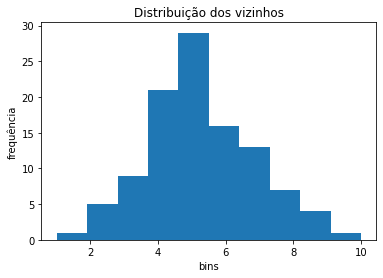

In [35]:
pd.Series(w_queen.cardinalities).plot.hist()
plt.xlabel("bins")
plt.ylabel("frequency")
plt.title("Neighbours distribution")
plt.show()

In [36]:
w_queen.histogram

[(1, 1),
 (2, 5),
 (3, 9),
 (4, 21),
 (5, 29),
 (6, 16),
 (7, 13),
 (8, 7),
 (9, 4),
 (10, 1)]

In [37]:
w_queen.mean_neighbors

5.245283018867925

In [38]:
w_queen.neighbors

{0: [1, 2, 4, 102, 105, 13, 16, 89, 91],
 1: [0, 16, 4, 7, 11, 12],
 2: [0, 89, 10, 27, 13],
 3: [97, 5, 8, 12, 18, 84, 85, 60],
 4: [0, 1, 17, 9, 11, 13],
 5: [3, 67, 85, 60, 63],
 6: [8, 73, 14],
 7: [1, 11, 12, 14],
 8: [3, 6, 60, 73, 12, 14, 15],
 9: [17, 4],
 10: [2, 38, 89, 27, 28],
 11: [1, 4, 14, 7],
 12: [1, 3, 7, 8, 14, 15, 16, 18],
 13: [0, 17, 2, 4, 27],
 14: [6, 7, 8, 11, 12],
 15: [8, 12],
 16: [0, 1, 18, 91, 12],
 17: [33, 4, 9, 27, 13],
 18: [16, 97, 3, 91, 12],
 19: [57, 59],
 20: [96, 22, 56, 75, 77],
 21: [56, 46, 22],
 22: [56, 20, 21],
 23: [24, 49, 53, 25],
 24: [49, 50, 37, 54, 23, 25, 26],
 25: [24, 37, 53, 23],
 26: [32, 36, 37, 38, 41, 42, 54, 24, 31],
 27: [33, 2, 35, 10, 13, 17, 28, 30],
 28: [34, 35, 10, 38, 42, 27, 29],
 29: [34, 35, 39, 40, 28],
 30: [40, 27, 35],
 31: [32, 26, 37],
 32: [34, 26, 42, 31],
 33: [17, 27],
 34: [32, 39, 42, 28, 29],
 35: [40, 27, 28, 29, 30],
 36: [83, 26, 54, 41, 90],
 37: [24, 25, 26, 31],
 38: [89, 10, 26, 41, 42, 28, 95]

In [39]:
pd.DataFrame(*w_queen.full()).astype(float)

,0,1,2,3,4,5,6,7,8,9,...,96,97,98,99,100,101,102,103,104,105
0,0.000000,0.111111,0.111111,0.0,0.111111,0.000,0.0,0.000000,0.000,0.000000,...,0.0,0.000,0.00,0.0,0.0,0.0,0.111111,0.0,0.000000,0.111111
1,0.166667,0.000000,0.000000,0.0,0.166667,0.000,0.0,0.166667,0.000,0.000000,...,0.0,0.000,0.00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
2,0.200000,0.000000,0.000000,0.0,0.000000,0.000,0.0,0.000000,0.000,0.000000,...,0.0,0.000,0.00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.0,0.000000,0.125,0.0,0.000000,0.125,0.000000,...,0.0,0.125,0.00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
4,0.166667,0.166667,0.000000,0.0,0.000000,0.000,0.0,0.000000,0.000,0.166667,...,0.0,0.000,0.00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,0.000000,0.000000,0.000000,0.0,0.000000,0.000,0.0,0.000000,0.000,0.000000,...,0.0,0.000,0.00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
102,0.142857,0.000000,0.000000,0.0,0.000000,0.000,0.0,0.000000,0.000,0.000000,...,0.0,0.000,0.00,0.0,0.0,0.0,0.000000,0.0,0.142857,0.142857
103,0.000000,0.000000,0.000000,0.0,0.000000,0.000,0.0,0.000000,0.000,0.000000,...,0.0,0.000,0.25,0.0,0.0,0.0,0.000000,0.0,0.250000,0.000000
104,0.000000,0.000000,0.000000,0.0,0.000000,0.000,0.0,0.000000,0.000,0.000000,...,0.0,0.100,0.10,0.0,0.0,0.0,0.100000,0.1,0.000000,0.100000


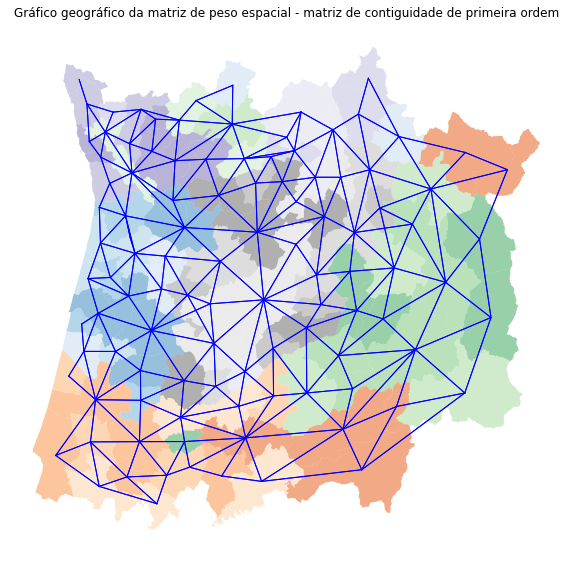

In [40]:
figure, ax = plt.subplots(figsize = (10,10) )
ax.use_sticky_edges = False

w_queen.plot(df, ax=ax,
        edge_kws=dict(color='blue', linestyle='-', linewidth=1),
        node_kws=dict(marker='', color='black'))


df.plot(ax=ax, column=('Dicofre'), 
                               cmap = "tab20c",
                               alpha = 0.5
                               ) 

ax.set_axis_off()

ax.set_title('Spatial weight matrix geographic plot - first order contiguity matrix')

plt.show()

In [41]:
df['COVID_confirmados_10mil_hab_lag_w_queen'] = weights.spatial_lag.lag_spatial(
    w_queen, df['COVID_confirmados_10mil_hab']
)

In [42]:
df[["Concelho","COVID_confirmados_10mil_hab_lag_w_queen", "COVID_confirmados_10mil_hab"]]

,Concelho,COVID_confirmados_10mil_hab_lag_w_queen,COVID_confirmados_10mil_hab
0,Águeda,44.384444,42.32
1,Albergaria-a-Velha,55.908333,60.59
2,Anadia,38.138000,38.08
3,Arouca,74.681250,121.65
4,Aveiro,46.858333,79.80
...,...,...,...
101,Tarouca,42.200000,8.70
102,Tondela,31.707143,16.24
103,Vila Nova de Paiva,42.905000,21.25
104,Viseu,29.608000,36.57


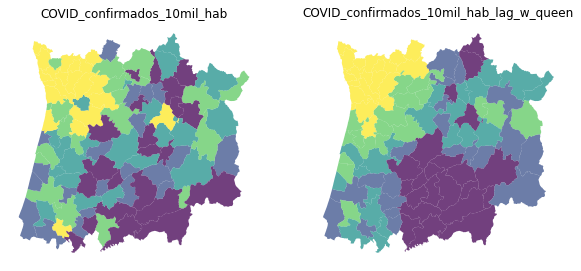

In [43]:
f, axs = plt.subplots(1, 2, figsize=(10, 10))
ax1, ax2 = axs

df.plot(
    column='COVID_confirmados_10mil_hab',
    cmap='viridis',
    scheme='quantiles',
    k=5,
    edgecolor='white',
    linewidth=0.,
    alpha=0.75,
    legend=False,
    ax=ax1
)
ax1.set_axis_off()
ax1.set_title("COVID_confirmados_10mil_hab")

df.plot(
    column='COVID_confirmados_10mil_hab_lag_w_queen',
    cmap='viridis',
    scheme='quantiles',
    k=5,
    edgecolor='white',
    linewidth=0.,
    alpha=0.75,
    legend=False,
    ax=ax2
)
ax2.set_axis_off()
ax2.set_title("COVID_confirmados_10mil_hab_lag_w_queen")

plt.show()

#### 2. Distance Based Weights (DBW)

In [44]:

km = 40
metros = km * 10 ** 3
wd = weights.distance.DistanceBand.from_dataframe(df, threshold = metros) # to run the tobler distance, include the arg:  alpha=-2)

wd.transform = 'R'

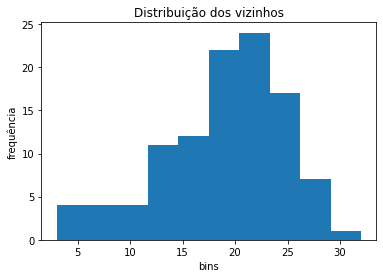

In [45]:
pd.Series(wd.cardinalities).plot.hist()
plt.xlabel("bins")
plt.ylabel("frequency")
plt.title("Neighbours distribution")
plt.show()

In [46]:
wd.histogram

[(3, 2),
 (4, 0),
 (5, 2),
 (6, 0),
 (7, 1),
 (8, 3),
 (9, 1),
 (10, 0),
 (11, 3),
 (12, 5),
 (13, 3),
 (14, 3),
 (15, 6),
 (16, 4),
 (17, 2),
 (18, 7),
 (19, 7),
 (20, 8),
 (21, 6),
 (22, 8),
 (23, 10),
 (24, 7),
 (25, 9),
 (26, 1),
 (27, 5),
 (28, 1),
 (29, 1),
 (30, 0),
 (31, 0),
 (32, 1)]

In [47]:
wd.mean_neighbors

18.9811320754717

In [48]:
wd.neighbors

{0: [1,
  2,
  3,
  4,
  7,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  27,
  33,
  38,
  83,
  89,
  91,
  95,
  97,
  102,
  105],
 1: [0,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  33,
  89,
  91,
  97,
  102,
  105],
 2: [0,
  1,
  4,
  7,
  9,
  10,
  11,
  13,
  16,
  17,
  27,
  28,
  29,
  33,
  34,
  35,
  38,
  41,
  42,
  83,
  89,
  91,
  95,
  102,
  105],
 3: [0,
  1,
  5,
  6,
  7,
  8,
  12,
  14,
  15,
  16,
  18,
  58,
  60,
  61,
  63,
  66,
  67,
  71,
  73,
  84,
  85,
  86,
  91,
  94,
  97,
  104,
  105],
 4: [0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 27, 33, 91],
 5: [1,
  3,
  6,
  7,
  8,
  12,
  14,
  15,
  16,
  18,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  70,
  71,
  73,
  74,
  76,
  84,
  85,
  91,
  94,
  97],
 6: [1,
  3,
  4,
  5,
  7,
  8,
  11,
  12,
  14,
  15,
  16,
  18,
  60,
  62,
  64,
  65,
  66,
  67,
  68,
  70,
  71,
  72,
 

In [49]:
pd.DataFrame(*wd.full()).astype(float)

,0,1,2,3,4,5,6,7,8,9,...,96,97,98,99,100,101,102,103,104,105
0,0.000000,0.040000,0.040000,0.040000,0.040000,0.000000,0.000000,0.040000,0.000000,0.040000,...,0.00,0.040000,0.000000,0.00,0.00,0.000000,0.040000,0.000000,0.000000,0.040000
1,0.041667,0.000000,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,0.041667,...,0.00,0.041667,0.000000,0.00,0.00,0.000000,0.041667,0.000000,0.000000,0.041667
2,0.040000,0.040000,0.000000,0.000000,0.040000,0.000000,0.000000,0.040000,0.000000,0.040000,...,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.040000,0.000000,0.000000,0.040000
3,0.037037,0.037037,0.000000,0.000000,0.000000,0.037037,0.037037,0.037037,0.037037,0.000000,...,0.00,0.037037,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.037037,0.037037
4,0.052632,0.052632,0.052632,0.000000,0.000000,0.000000,0.052632,0.052632,0.052632,0.052632,...,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.04,0.040000,0.040000,0.04,0.04,0.000000,0.000000,0.040000,0.040000,0.000000
102,0.045455,0.045455,0.045455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.045455,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.045455,0.045455
103,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.04,0.040000,0.040000,0.04,0.04,0.040000,0.000000,0.000000,0.040000,0.040000
104,0.000000,0.000000,0.000000,0.045455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.045455,0.045455,0.00,0.00,0.045455,0.045455,0.045455,0.000000,0.045455


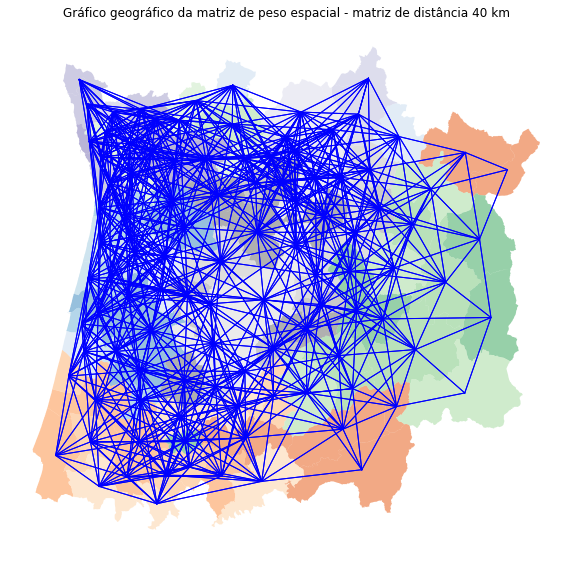

In [50]:
figure, ax = plt.subplots(figsize = (10,10) )
ax.use_sticky_edges = False

wd.plot(df, ax=ax,
        edge_kws=dict(color='blue', linestyle='-', linewidth=1),
        node_kws=dict(marker='', color='black'))


df.plot(ax=ax, column=('Dicofre'), 
                               cmap = "tab20c",
                               alpha = 0.5
                               ) 

ax.set_axis_off()

ax.set_title(f'Spatial weight matrix geographic plot - distance matrix {km} km')

plt.show()

Em média, cada concelho tem 19 vizinhos através da matriz de pesos distancia

In [51]:
# calcular os valores dos lags espaciais de uma variável especifica - COVID_confirmados_10mil_hab
df['COVID_confirmados_10mil_hab_lag_w100'] = weights.spatial_lag.lag_spatial(
    wd, df['COVID_confirmados_10mil_hab']
)

In [52]:
# comparar os valores da variável e os desfasamentos espaciais
df[["Concelho","COVID_confirmados_10mil_hab_lag_w100","COVID_confirmados_10mil_hab"]]

,Concelho,COVID_confirmados_10mil_hab_lag_w100,COVID_confirmados_10mil_hab
0,Águeda,52.858000,42.32
1,Albergaria-a-Velha,56.012083,60.59
2,Anadia,44.232000,38.08
3,Arouca,83.322593,121.65
4,Aveiro,59.484211,79.80
...,...,...,...
101,Tarouca,48.794400,8.70
102,Tondela,37.325000,16.24
103,Vila Nova de Paiva,44.260800,21.25
104,Viseu,37.805000,36.57


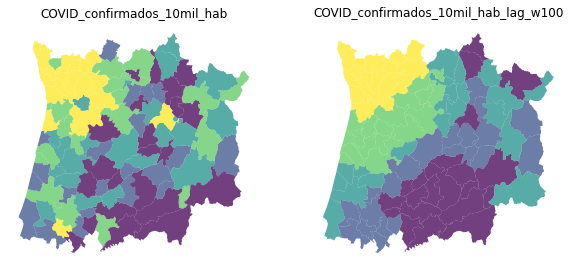

In [53]:
f, axs = plt.subplots(1, 2, figsize=(10, 10))
ax1, ax2 = axs

df.plot(
    column='COVID_confirmados_10mil_hab',
    cmap='viridis',
    scheme='quantiles',
    k=5,
    edgecolor='white',
    linewidth=0.,
    alpha=0.75,
    legend=False,
    ax=ax1
)
ax1.set_axis_off()
ax1.set_title("COVID_confirmados_10mil_hab")

df.plot(
    column='COVID_confirmados_10mil_hab_lag_w100',
    cmap='viridis',
    scheme='quantiles',
    k=5,
    edgecolor='white',
    linewidth=0.,
    alpha=0.75,
    legend=False,
    ax=ax2
)
ax2.set_axis_off()
ax2.set_title("COVID_confirmados_10mil_hab_lag_w100")

plt.show()

#### 3. DBW: K-Nearest Neighbor weights

In [54]:
k = 3
w_KNN = weights.distance.KNN.from_dataframe(df, k = k)

w_KNN.transform = 'R'

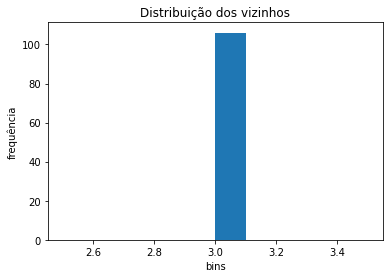

In [55]:
pd.Series(w_KNN.cardinalities).plot.hist()
plt.xlabel("bins")
plt.ylabel("frequency")
plt.title("Neighbours distribution")
plt.show()

In [56]:
w_KNN.histogram

[(3, 106)]

In [57]:
w_KNN.mean_neighbors

3.0

In [58]:
w_KNN.neighbors

{0: [1, 13, 2],
 1: [7, 16, 4],
 2: [10, 13, 0],
 3: [5, 18, 85],
 4: [9, 1, 11],
 5: [3, 67, 85],
 6: [73, 8, 14],
 7: [11, 1, 12],
 8: [15, 6, 73],
 9: [4, 17, 13],
 10: [2, 28, 38],
 11: [7, 4, 14],
 12: [15, 18, 7],
 13: [2, 17, 0],
 14: [15, 6, 7],
 15: [12, 8, 14],
 16: [91, 18, 1],
 17: [9, 33, 13],
 18: [12, 16, 3],
 19: [57, 59, 61],
 20: [96, 75, 56],
 21: [22, 46, 56],
 22: [21, 56, 20],
 23: [50, 24, 49],
 24: [50, 25, 54],
 25: [24, 23, 50],
 26: [41, 31, 37],
 27: [33, 35, 10],
 28: [29, 10, 34],
 29: [40, 28, 34],
 30: [35, 40, 27],
 31: [32, 37, 26],
 32: [34, 42, 31],
 33: [17, 27, 13],
 34: [32, 39, 42],
 35: [30, 27, 40],
 36: [54, 41, 83],
 37: [31, 26, 32],
 38: [42, 89, 10],
 39: [34, 29, 32],
 40: [29, 35, 30],
 41: [95, 26, 83],
 42: [38, 32, 34],
 43: [98, 99, 47],
 44: [52, 46, 53],
 45: [47, 49, 55],
 46: [52, 51, 56],
 47: [45, 92, 43],
 48: [50, 87, 47],
 49: [45, 23, 53],
 50: [48, 24, 54],
 51: [93, 56, 55],
 52: [55, 46, 44],
 53: [49, 23, 44],
 54: [36,

In [59]:
pd.DataFrame(*w_KNN.full()).astype(float)

,0,1,2,3,4,5,6,7,8,9,...,96,97,98,99,100,101,102,103,104,105
0,0.000000,0.333333,0.333333,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
1,0.000000,0.000000,0.000000,0.0,0.333333,0.000000,0.0,0.333333,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
2,0.333333,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
3,0.000000,0.000000,0.000000,0.0,0.000000,0.333333,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
4,0.000000,0.333333,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.333333,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
102,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.333333
103,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.333333,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
104,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.333333


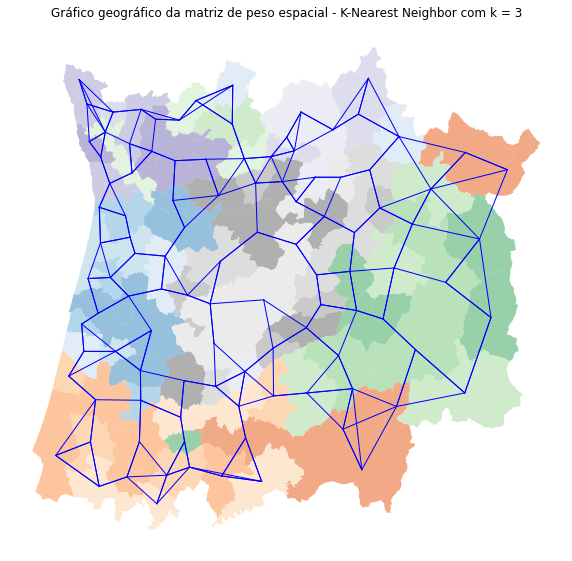

In [60]:
figure, ax = plt.subplots(figsize = (10,10) )
ax.use_sticky_edges = False

w_KNN.plot(df, ax=ax,
        edge_kws=dict(color='blue', linestyle='-', linewidth=1),
        node_kws=dict(marker='', color='black'))


df.plot(ax=ax, column=('Dicofre'), 
                               cmap = "tab20c",
                               alpha = 0.5
                               ) 

ax.set_axis_off()

ax.set_title(f'Spatial weight matrix geographic plot - K-Nearest Neighbor with k = {k}')

plt.show()

In [61]:
df['COVID_confirmados_10mil_hab_lag_w_KNN'] = weights.spatial_lag.lag_spatial(
    w_KNN, df['COVID_confirmados_10mil_hab']
)

In [62]:
df[["Concelho","COVID_confirmados_10mil_hab_lag_w_KNN","COVID_confirmados_10mil_hab"]]

,Concelho,COVID_confirmados_10mil_hab_lag_w_KNN,COVID_confirmados_10mil_hab
0,Águeda,47.510000,42.32
1,Albergaria-a-Velha,65.163333,60.59
2,Anadia,37.700000,38.08
3,Arouca,83.750000,121.65
4,Aveiro,54.340000,79.80
...,...,...,...
101,Tarouca,29.103333,8.70
102,Tondela,26.543333,16.24
103,Vila Nova de Paiva,45.016667,21.25
104,Viseu,40.370000,36.57


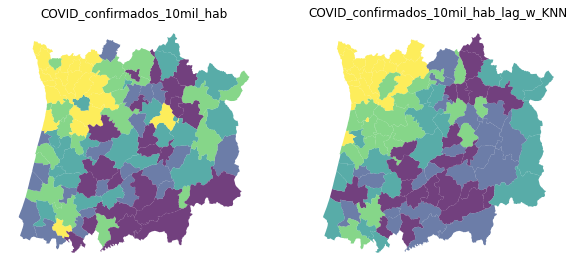

In [63]:
f, axs = plt.subplots(1, 2, figsize=(10, 10))
ax1, ax2 = axs

df.plot(
    column='COVID_confirmados_10mil_hab',
    cmap='viridis',
    scheme='quantiles',
    k=5,
    edgecolor='white',
    linewidth=0.,
    alpha=0.75,
    legend=False,
    ax=ax1
)
ax1.set_axis_off()
ax1.set_title("COVID_confirmados_10mil_hab")

df.plot(
    column='COVID_confirmados_10mil_hab_lag_w_KNN',
    cmap='viridis',
    scheme='quantiles',
    k=5,
    edgecolor='white',
    linewidth=0.,
    alpha=0.75,
    legend=False,
    ax=ax2
)
ax2.set_axis_off()
ax2.set_title("COVID_confirmados_10mil_hab_lag_w_KNN")


plt.show()

#### DBW: Kernel weights

In [64]:
w_Kernel = weights.distance.Kernel.from_dataframe(df)

w_Kernel.transform = 'R'

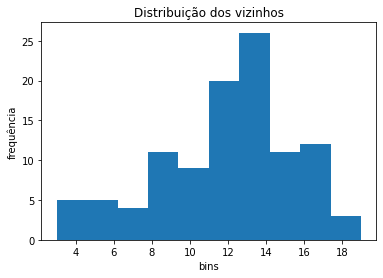

In [65]:
pd.Series(w_Kernel.cardinalities).plot.hist()
plt.xlabel("bins")
plt.ylabel("frequency")
plt.title("Neighbours distribution")
plt.show()

In [66]:
w_Kernel.histogram

[(3, 3),
 (4, 2),
 (5, 3),
 (6, 2),
 (7, 4),
 (8, 5),
 (9, 6),
 (10, 9),
 (11, 8),
 (12, 12),
 (13, 14),
 (14, 12),
 (15, 11),
 (16, 9),
 (17, 3),
 (18, 1),
 (19, 2)]

In [67]:
# Vizinhos Médios de Pesos Espaciais
w_Kernel.mean_neighbors

11.830188679245284

In [68]:
# Representação da Matriz de Pesos Espaciais
w_Kernel.neighbors

{0: [10, 9, 17, 4, 13, 1, 2, 0, 16, 89, 91, 105, 102, 7, 12, 18],
 1: [9, 17, 4, 13, 1, 2, 0, 16, 91, 11, 14, 7, 15, 12, 18],
 2: [27, 28, 10, 38, 95, 33, 9, 17, 4, 13, 1, 2, 0, 89, 102],
 3: [16, 91, 8, 15, 60, 12, 18, 5, 3, 85, 67, 63, 97, 84],
 4: [33, 9, 17, 4, 13, 1, 2, 0, 16, 11, 14, 7, 12],
 5: [6, 73, 8, 15, 60, 12, 18, 5, 3, 85, 71, 66, 67, 63, 97],
 6: [11, 6, 14, 73, 7, 8, 15, 60, 12, 5, 64, 68, 62, 71, 66],
 7: [9, 17, 4, 13, 1, 0, 16, 91, 11, 6, 14, 7, 8, 15, 12, 18],
 8: [11, 6, 14, 73, 7, 8, 15, 60, 12, 18, 5, 3, 68, 71, 66, 67],
 9: [27, 33, 9, 17, 4, 13, 1, 2, 0, 11, 7],
 10: [35, 27, 29, 28, 10, 34, 38, 42, 95, 33, 17, 13, 2, 0, 89],
 11: [9, 17, 4, 13, 1, 16, 11, 6, 14, 7, 8, 15, 12],
 12: [4, 1, 0, 16, 91, 11, 6, 14, 73, 7, 8, 15, 12, 18, 5, 3],
 13: [27, 10, 33, 9, 17, 4, 13, 1, 2, 0, 16, 89, 11, 7],
 14: [4, 1, 16, 11, 6, 14, 73, 7, 8, 15, 60, 12, 18],
 15: [1, 16, 11, 6, 14, 73, 7, 8, 15, 60, 12, 18, 5, 3],
 16: [4, 13, 1, 0, 16, 91, 105, 102, 11, 14, 7, 15, 12, 

In [69]:
pd.DataFrame(*w_Kernel.full()).astype(float)

,0,1,2,3,4,5,6,7,8,9,...,96,97,98,99,100,101,102,103,104,105
0,0.211510,0.101572,0.100770,0.000000,0.062435,0.000000,0.0,0.032930,0.00000,0.024897,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.041182,0.000000,0.000000,0.039465
1,0.079913,0.166407,0.008282,0.000000,0.092938,0.000000,0.0,0.111780,0.00000,0.051752,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.108533,0.011337,0.227803,0.000000,0.023588,0.000000,0.0,0.000000,0.00000,0.012729,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.002748,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.221237,0.000000,0.139423,0.0,0.000000,0.05358,0.000000,...,0.0,0.083848,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.056410,0.106728,0.019787,0.000000,0.191098,0.000000,0.0,0.099924,0.00000,0.143744,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,...,0.0,0.000000,0.007288,0.028938,0.061815,0.172166,0.000000,0.079745,0.000000,0.000000
102,0.049206,0.000000,0.003049,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.252719,0.000000,0.042269,0.126075
103,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,...,0.0,0.005442,0.125811,0.058539,0.000000,0.108821,0.000000,0.234940,0.044640,0.000000
104,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,...,0.0,0.077554,0.075620,0.000000,0.000000,0.000000,0.048122,0.054668,0.287716,0.093241


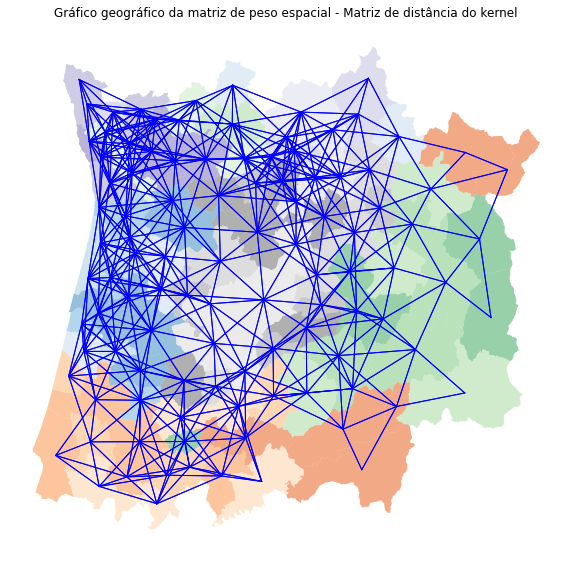

In [70]:
figure, ax = plt.subplots(figsize = (10,10) )
ax.use_sticky_edges = False

w_Kernel.plot(df, ax=ax,
        edge_kws=dict(color='blue', linestyle='-', linewidth=1),
        node_kws=dict(marker='', color='black'))


df.plot(ax=ax, column=('Dicofre'), 
                               cmap = "tab20c",
                               alpha = 0.5
                               ) 

ax.set_axis_off()

ax.set_title('Spatial weight matrix geographic plot - Kernel distance matrix')

plt.show()

In [71]:
df['COVID_confirmados_10mil_hab_lag_w_Kernel'] = weights.spatial_lag.lag_spatial(
    w_Kernel, df['COVID_confirmados_10mil_hab']
)

In [72]:
df[["Concelho","COVID_confirmados_10mil_hab_lag_w_Kernel","COVID_confirmados_10mil_hab"]]

,Concelho,COVID_confirmados_10mil_hab_lag_w_Kernel,COVID_confirmados_10mil_hab
0,Águeda,46.935990,42.32
1,Albergaria-a-Velha,63.103953,60.59
2,Anadia,39.494939,38.08
3,Arouca,82.600862,121.65
4,Aveiro,57.203966,79.80
...,...,...,...
101,Tarouca,40.840575,8.70
102,Tondela,27.149444,16.24
103,Vila Nova de Paiva,40.571894,21.25
104,Viseu,31.975526,36.57


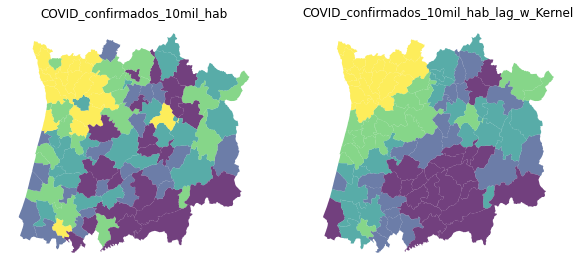

In [73]:
f, axs = plt.subplots(1, 2, figsize=(10, 10))
ax1, ax2 = axs

df.plot(
    column='COVID_confirmados_10mil_hab',
    cmap='viridis',
    scheme='quantiles',
    k=5,
    edgecolor='white',
    linewidth=0.,
    alpha=0.75,
    legend=False,
    ax=ax1
)
ax1.set_axis_off()
ax1.set_title("COVID_confirmados_10mil_hab")

df.plot(
    column='COVID_confirmados_10mil_hab_lag_w_Kernel',
    cmap='viridis',
    scheme='quantiles',
    k=5,
    edgecolor='white',
    linewidth=0.,
    alpha=0.75,
    legend=False,
    ax=ax2
)
ax2.set_axis_off()
ax2.set_title("COVID_confirmados_10mil_hab_lag_w_Kernel")

plt.show()

#### Synthesis

Four different spatial weight matrices were used: 
1. Contiguity weights
2. Distance-based weights
3. Distance-based weights - K-Nearest Neighbor weights
4. Distance-based weights - kernel weights

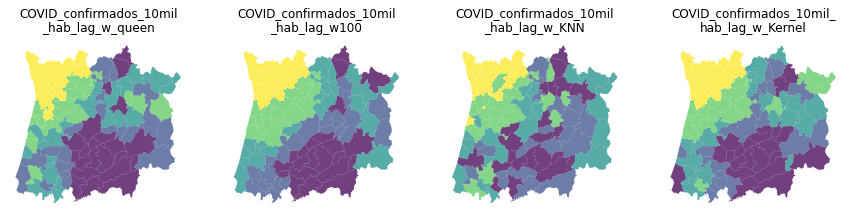

In [74]:
f, axs = plt.subplots(1, 4, figsize=(15, 15))
ax1, ax2, ax3, ax4 = axs

df.plot(
    column='COVID_confirmados_10mil_hab_lag_w_queen',
    cmap='viridis',
    scheme='quantiles',
    k=5,
    edgecolor='white',
    linewidth=0.,
    alpha=0.75,
    legend=False,
    ax=ax1
)
ax1.set_axis_off()
ax1.set_title("COVID_confirmados_10mil\n_hab_lag_w_queen")

df.plot(
    column='COVID_confirmados_10mil_hab_lag_w100',
    cmap='viridis',
    scheme='quantiles',
    k=5,
    edgecolor='white',
    linewidth=0.,
    alpha=0.75,
    legend=False,
    ax=ax2
)
ax2.set_axis_off()
ax2.set_title("COVID_confirmados_10mil\n_hab_lag_w100")
        

df.plot(
    column='COVID_confirmados_10mil_hab_lag_w_KNN',
    cmap='viridis',
    scheme='quantiles',
    k=5,
    edgecolor='white',
    linewidth=0.,
    alpha=0.75,
    legend=False,
    ax=ax3
)
ax3.set_axis_off()
ax3.set_title("COVID_confirmados_10mil\n_hab_lag_w_KNN")

df.plot(
    column='COVID_confirmados_10mil_hab_lag_w_Kernel',
    cmap='viridis',
    scheme='quantiles',
    k=5,
    edgecolor='white',
    linewidth=0.,
    alpha=0.75,
    legend=False,
    ax=ax4
)
ax4.set_axis_off()
ax4.set_title("COVID_confirmados_10mil_\nhab_lag_w_Kernel")

plt.show()

#### 6. Moran´s index

In [75]:
d = {"Queen weights": w_queen, 
    f"Distance weights - {km} km": wd, 
    "KNN weights": w_KNN, 
    "Kernel weights" : w_Kernel}

for s, w in d.items():
    moran = Moran(df['COVID_confirmados_10mil_hab'], w)
    print(s + ":", moran.I, "with p-value:", moran.p_sim)

Pesos Rainha: 0.4866488292504185 com p-value: 0.001
Pesos Distância - 40 km: 0.4193371962756764 com p-value: 0.001
Pesos KNN: 0.5256099522031066 com p-value: 0.001
Pesos Kernel: 0.5921250205614831 com p-value: 0.001


Given that all index values are positive with significant p-values, we reject the null hypothesis that the spatial distribution of high and/or low values in the data set is more spatially clustered than would be expected if the underlying spatial processes were random.

### Econometric models

$$
\mathbf{Y_i} = \alpha + \sum_k \mathbf{X}_{ik}\beta_k  + \epsilon_i
$$

Spatial regression steps:

* Construct the spatial matrix of weights.
* Exploratory analysis - examine relationships and measure spatial autocorrelation
* Run OLS regression to verify what type of spatial regression will be used
* Run spatial regression

The weight matrix with the highest Moran index is the kernel matrix, however for regression it is necessary that the main diagonal of the matrix is 0 so the second best with this property was chosen: KNN

In [76]:
W_selected = w_KNN #w_Kernel
w_str = "KNN" #"Kernel"

moran_l = esda.moran.Moran_Local(df['COVID_confirmados_10mil_hab'], W_selected)

#### PCA for dimensionality reduction

In [77]:
X_pca = df[['IVolumetria', 
             'vagos_perc', 
             'IMedia_edif',
             'aloj_habitual_perc', 
             'dimensao_aloj', 
             'aloj_por_familia',
             'arrendamento_perc',
             'ind_envelhecimento', 
             'ind_qualificacoes',
             'ind_migraçao', 
             'primario_perc', 
             'secundario_perc', 
             'terciario_perc',
             'divisoes_n']]
X_pca.head()

,IVolumetria,vagos_perc,IMedia_edif,aloj_habitual_perc,dimensao_aloj,aloj_por_familia,arrendamento_perc,ind_envelhecimento,ind_qualificacoes,ind_migraçao,primario_perc,secundario_perc,terciario_perc,divisoes_n
0,1.73,0.13,36.10,0.76,144.41,1.31,0.08,101.84,7.65,96.42,0.01,0.49,0.49,3.39
1,1.71,0.14,38.21,0.74,136.91,1.33,0.07,86.86,7.63,96.08,0.02,0.45,0.53,3.38
2,1.63,0.15,37.80,0.72,148.89,1.39,0.06,133.94,7.67,96.62,0.04,0.40,0.57,3.39
3,1.65,0.09,34.21,0.69,128.59,1.44,0.06,83.43,7.11,95.60,0.07,0.46,0.48,3.32
4,2.00,0.12,35.72,0.75,134.47,1.31,0.17,84.75,8.87,101.39,0.01,0.28,0.70,3.40


In [78]:
X_pca.corr()

,IVolumetria,vagos_perc,IMedia_edif,aloj_habitual_perc,dimensao_aloj,aloj_por_familia,arrendamento_perc,ind_envelhecimento,ind_qualificacoes,ind_migraçao,primario_perc,secundario_perc,terciario_perc,divisoes_n
IVolumetria,1.000000,0.018887,0.275721,0.138404,-0.314362,-0.094219,0.543297,-0.006161,0.442511,0.371451,-0.316508,-0.153192,0.420363,0.110616
vagos_perc,0.018887,1.000000,0.253251,-0.087747,0.073310,0.040220,-0.097994,0.022803,0.156088,-0.099050,-0.171023,-0.110323,0.266551,0.014970
IMedia_edif,0.275721,0.253251,1.000000,-0.342145,-0.449521,0.341120,-0.020469,0.391159,-0.050097,0.090032,0.177437,-0.362149,0.269876,-0.301839
aloj_habitual_perc,0.138404,-0.087747,-0.342145,1.000000,0.240304,-0.968219,0.751731,-0.765564,0.528057,0.141191,-0.544554,0.481257,-0.125562,0.393057
dimensao_aloj,-0.314362,0.073310,-0.449521,0.240304,1.000000,-0.262795,-0.178332,-0.229389,0.269104,-0.107398,-0.259532,0.241355,-0.068220,0.413030
aloj_por_familia,-0.094219,0.040220,0.341120,-0.968219,-0.262795,1.000000,-0.680544,0.798085,-0.531304,-0.128173,0.477823,-0.430379,0.121361,-0.349825
arrendamento_perc,0.543297,-0.097994,-0.020469,0.751731,-0.178332,-0.680544,1.000000,-0.546244,0.606916,0.342107,-0.470040,0.195461,0.138474,0.274644
ind_envelhecimento,-0.006161,0.022803,0.391159,-0.765564,-0.229389,0.798085,-0.546244,1.000000,-0.412782,0.094706,0.357733,-0.427119,0.211515,-0.288348
ind_qualificacoes,0.442511,0.156088,-0.050097,0.528057,0.269104,-0.531304,0.606916,-0.412782,1.000000,0.398002,-0.519919,-0.168626,0.594044,0.294835
ind_migraçao,0.371451,-0.099050,0.090032,0.141191,-0.107398,-0.128173,0.342107,0.094706,0.398002,1.000000,-0.111774,-0.217441,0.330622,0.005239


In [79]:
pca = prince.PCA(
     n_components=4,
     n_iter=3,
     rescale_with_mean=True,
     rescale_with_std=True,
     copy=True,
     check_input=True,
     engine='auto',
     random_state=42
 )
pca = pca.fit(X_pca)

In [80]:
pca.explained_inertia_

array([0.34240442, 0.21349555, 0.1137353 , 0.08287201])

In [81]:
pca_correlations_df = pca.column_correlations(X_pca)
pca_correlations_df

,0,1,2,3
IMedia_edif,0.407434,0.520307,-0.197375,0.467558
IVolumetria,-0.256796,0.707337,-0.250583,0.152248
aloj_habitual_perc,-0.933717,-0.072466,-0.171674,-0.015861
aloj_por_familia,0.905929,0.084855,0.135889,0.032903
arrendamento_perc,-0.761035,0.381857,-0.408614,0.053354
dimensao_aloj,-0.344212,-0.360017,0.706563,-0.251193
divisoes_n,-0.560553,-0.079764,0.398405,0.018368
ind_envelhecimento,0.787290,0.224641,0.120590,-0.029105
ind_migraçao,-0.181336,0.565909,-0.162857,-0.416827
ind_qualificacoes,-0.658162,0.585341,0.267218,-0.151706


As variáveis que apresentam maiores loadings são:

In [82]:
pca_correlations_df = abs(pca_correlations_df)
Ind_var_columns = [pca_correlations_df.iloc[:, n].idxmax() for n in range(pca_correlations_df.shape[1])]
Ind_var_columns

['aloj_habitual_perc', 'terciario_perc', 'dimensao_aloj', 'vagos_perc']

In [83]:
pca.transform(X_pca)

,0,1,2,3
0,-2.237132,-1.886218,0.584176,0.122470
1,-1.717798,-1.370068,0.345671,0.509490
2,-1.331652,-1.241315,1.587825,-0.115232
3,-0.466450,-2.414861,-1.307894,-0.401417
4,-3.308120,2.403210,0.395964,-1.661497
...,...,...,...,...
101,2.345921,-0.456677,1.855688,2.657570
102,0.272524,-0.561539,0.282290,0.156475
103,2.110901,-0.218213,0.988641,-0.490078
104,-2.052815,1.787904,1.124915,-1.763588


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


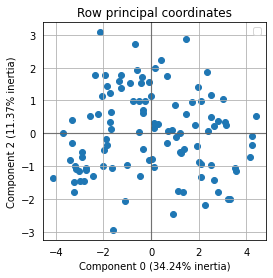

In [84]:
ax = pca.plot_row_coordinates(
     X_pca,
     figsize=(4, 4),
     x_component=0,
     y_component=2,
 )
ax.get_figure()
plt.show()

In [85]:
score_PCA = pca.row_contributions(X_pca)

In [86]:
score_PCA.columns=['factor1', 'factor2', 'factor3', 'factor4']
df.join(score_PCA)

,Dicomun,Concelho,Distrito,geometry,Dicofre,Freguesia,TAA,Area_T_ha,Area_EA_ha,Des_Simpli,...,COVIDConfirmadosAcum,COVID_confirmados_10mil_hab,COVID_confirmados_10mil_hab_lag_w_queen,COVID_confirmados_10mil_hab_lag_w100,COVID_confirmados_10mil_hab_lag_w_KNN,COVID_confirmados_10mil_hab_lag_w_Kernel,factor1,factor2,factor3,factor4
0,101,Águeda,Aveiro,"POLYGON ((-25647.507 93242.339, -25739.783 931...",010127,União das freguesias do Préstimo e Macieira de...,ÁREA PRINCIPAL,4172.64,4172.64,Préstimo e Macieira de Alcoba,...,202,42.32,44.384444,52.858000,47.510000,46.935990,1.044037,1.190328,0.214320,0.012928
1,102,Albergaria-a-Velha,Aveiro,"POLYGON ((-29040.418 108964.754, -29041.338 10...",010202,Alquerubim,ÁREA PRINCIPAL,1535.86,1535.86,Alquerubim,...,153,60.59,55.908333,56.012083,65.163333,63.103953,0.615569,0.628011,0.075041,0.223735
2,103,Anadia,Aveiro,"POLYGON ((-17967.760 83828.847, -17911.070 838...",010312,Vila Nova de Monsarros,ÁREA PRINCIPAL,2372.04,2372.04,Vila Nova de Monsarros,...,111,38.08,38.138000,44.232000,37.700000,39.494939,0.369925,0.515522,1.583369,0.011445
3,104,Arouca,Aveiro,"POLYGON ((-14528.269 134014.425, -14662.068 13...",010413,Mansores,ÁREA PRINCIPAL,1407.54,1407.54,Mansores,...,272,121.65,74.681250,83.322593,83.750000,82.600862,0.045388,1.951045,1.074290,0.138885
4,105,Aveiro,Aveiro,"POLYGON ((-34573.847 100271.486, -34730.113 10...",010513,Santa Joana,ÁREA PRINCIPAL,584.55,584.55,Santa Joana,...,626,79.80,46.858333,59.484211,54.340000,57.203966,2.282944,1.932265,0.098467,2.379375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,1820,Tarouca,Viseu,"POLYGON ((34344.274 148409.357, 34348.413 1484...",182013,União das freguesias de Tarouca e Dálvares,ÁREA PRINCIPAL,2191.66,2191.66,Tarouca e Dálvares,...,7,8.70,42.200000,48.794400,29.103333,40.840575,1.148046,0.069775,2.162653,6.087425
102,1821,Tondela,Viseu,"POLYGON ((2508.491 88461.830, 2479.582 88460.4...",182107,Ferreirós do Dão,ÁREA PRINCIPAL,828.64,828.64,Ferreirós do Dão,...,47,16.24,31.707143,37.325000,26.543333,27.149444,0.015493,0.105498,0.050046,0.021104
103,1822,Vila Nova de Paiva,Viseu,"POLYGON ((34808.673 122308.620, 34811.563 1222...",182204,Queiriga,ÁREA PRINCIPAL,3193.74,3193.74,Queiriga,...,11,21.25,42.905000,44.260800,45.016667,40.571894,0.929540,0.015931,0.613838,0.207012
104,1823,Viseu,Viseu,"POLYGON ((19440.461 101634.577, 19373.844 1015...",182327,São João de Lourosa,ÁREA PRINCIPAL,2600.41,2600.41,São João de Lourosa,...,363,36.57,29.608000,37.805000,40.370000,31.975526,0.879088,1.069477,0.794724,2.680762


#### Variable definition

In [87]:
Dep_Var = df['COVID_confirmados_10mil_hab']

Ind_Var = df[Ind_var_columns]

In [88]:
Ind_var_columns

['aloj_habitual_perc', 'terciario_perc', 'dimensao_aloj', 'vagos_perc']

In [89]:
df['COVID_confirmados_10mil_hab_lag'] = weights.lag_spatial(
    W_selected, df['COVID_confirmados_10mil_hab']
)


var_lag = []
for column in Ind_var_columns:
    column_lag = f'{column}_lag'
    df[column_lag] = weights.lag_spatial(W_selected, df[column])
    var_lag.append(column_lag)

In [90]:
Ind_Var_lag_columns = Ind_var_columns + var_lag
Ind_Var_lag_columns

['aloj_habitual_perc',
 'terciario_perc',
 'dimensao_aloj',
 'vagos_perc',
 'aloj_habitual_perc_lag',
 'terciario_perc_lag',
 'dimensao_aloj_lag',
 'vagos_perc_lag']

In [91]:
Ind_Var_lag = df[Ind_Var_lag_columns]

#### Non-spatial regression 

$$
\mathbf{Y_i} = \alpha + \sum_k \mathbf{X}_{ik}\beta_k  + \epsilon_i
$$

Non-spatial regression model construction

In [92]:
# modelo OLS
M_OLS = spreg.OLS(
    Dep_Var.values, # Dependent variable
    Ind_Var.values, # Independent variable
    name_y = 'COVID_confirmados_10mil_hab', # Dependent variable name 
    name_x = Ind_var_columns, #Independent variable name
    w = W_selected,
    spat_diag = True) 

print(M_OLS.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :COVID_confirmados_10mil_hab                Number of Observations:         106
Mean dependent var  :     59.2629                Number of Variables   :           5
S.D. dependent var  :     52.2712                Degrees of Freedom    :         101
R-squared           :      0.3956
Adjusted R-squared  :      0.3717
Sum squared residual:  173384.372                F-statistic           :     16.5298
Sigma-square        :    1716.677                Prob(F-statistic)     :   1.893e-10
S.E. of regression  :      41.433                Log likelihood        :    -542.598
Sigma-square ML     :    1635.702                Akaike info criterion :    1095.197
S.E of regression ML:     40.4438                Schwarz criterion     :    1108.514

--------------------------------------------------------------

Calculation of residuals to analyze in which county the model is less efficient

In [93]:
df['COVID_Predicted'] = M_OLS.predy
df['COVID_Predicted']

0      82.075497
1      80.917499
2      59.893946
3      88.418780
4      79.549011
         ...    
101    -4.941029
102    59.088550
103    10.099983
104    60.540527
105    51.209686
Name: COVID_Predicted, Length: 106, dtype: float64

In [94]:
df['residuals_OLS'] = M_OLS.u
df['residuals_OLS']

0     -39.755497
1     -20.327499
2     -21.813946
3      33.231220
4       0.250989
         ...    
101    13.641029
102   -42.848550
103    11.150017
104   -23.970527
105   -20.919686
Name: residuals_OLS, Length: 106, dtype: float64

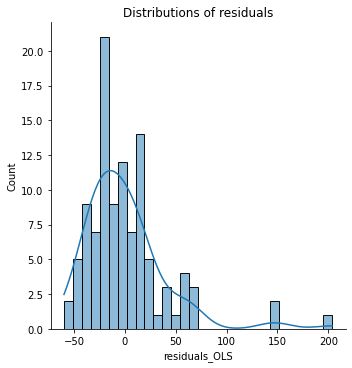

In [95]:
sns.displot(df['residuals_OLS'], bins=30,kde=True)
plt.title("Distributions of residuals")
plt.show()

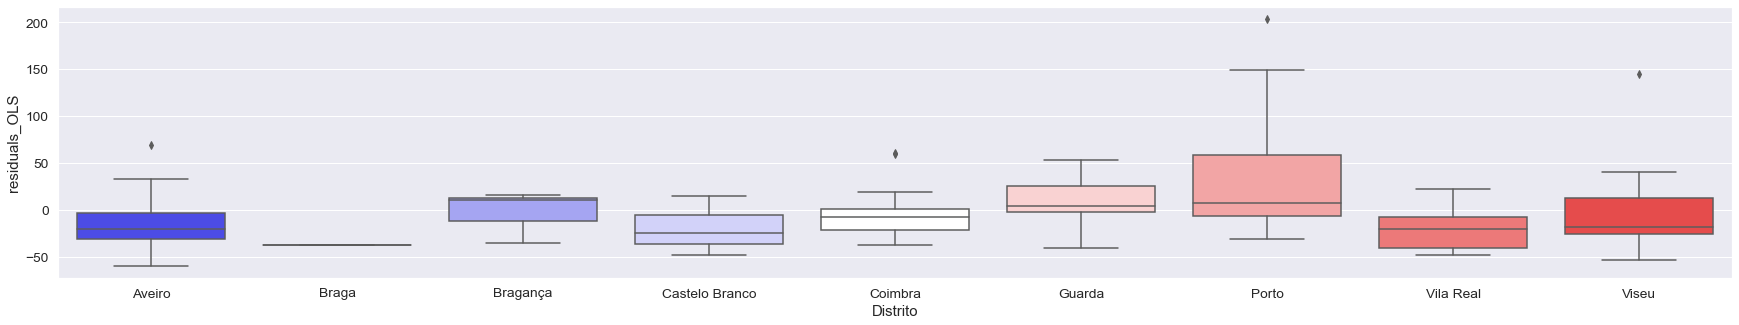

In [96]:
sns.set(font_scale = 1.25)
f = plt.figure(figsize=(30,5))
ax = plt.gca()

sns.boxplot(
    'Distrito', 
    'residuals_OLS', 
    data= df,
    ax = ax,
    palette='bwr'
    )
plt.show()

In [97]:
df['Z_Score_residuals_OLS'] = stats.zscore(df['residuals_OLS'])
df['Z_Score_residuals_OLS']

0     -0.982981
1     -0.502611
2     -0.539364
3      0.821664
4      0.006206
         ...   
101    0.337283
102   -1.059459
103    0.275692
104   -0.592687
105   -0.517253
Name: Z_Score_residuals_OLS, Length: 106, dtype: float64

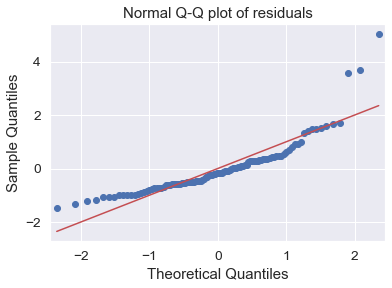

In [98]:
qqplot(df['Z_Score_residuals_OLS'], line='s')
plt.title("Normal Q-Q plot of residuals")
plt.show()

In [99]:
stat, p = kstest(df['Z_Score_residuals_OLS'], 'norm')
stat, p

(0.14553989636618136, 0.020104150505432794)

Using this p-value we can reject the null hypothesis that the residuals come from a normal distribution at a 5% significance level

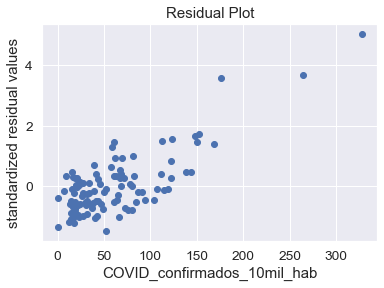

In [100]:
plt.scatter(df['COVID_confirmados_10mil_hab'], df['Z_Score_residuals_OLS'])
plt.title('Residual Plot')
plt.xlabel('COVID_confirmados_10mil_hab')
plt.ylabel('standardized residual values')
plt.show() 

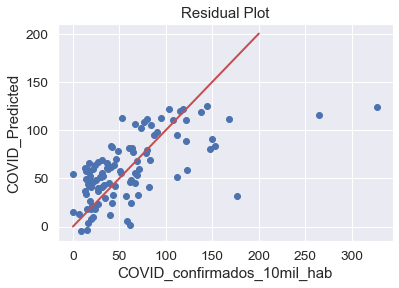

In [101]:
plt.scatter(df['COVID_confirmados_10mil_hab'], df['COVID_Predicted'])
plt.title('Residual Plot')
plt.xlabel('COVID_confirmados_10mil_hab')
plt.ylabel('COVID_Predicted')
plt.plot([0, 50, 100, 200], [0, 50, 100, 200],  linewidth=2, color='r')
plt.show() 

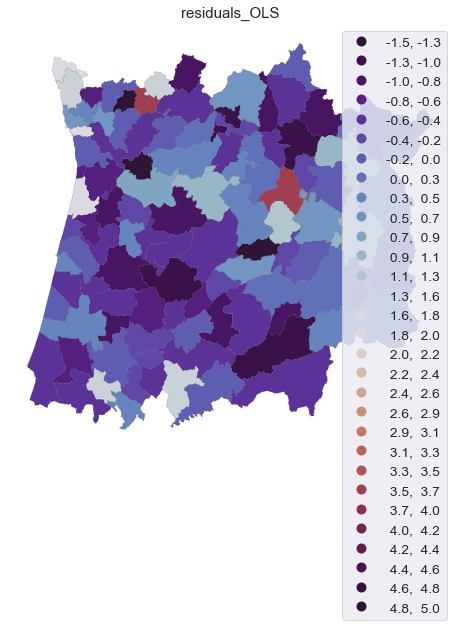

In [102]:
f, ax = plt.subplots(1, figsize=(8,12))
ax = df.plot(
    column='Z_Score_residuals_OLS',          
    scheme='EqualInterval',          
    cmap='twilight_shifted',               
    edgecolor='k',               
    linewidth=0.1,               
    legend=True,                 
    legend_kwds={'fmt':'{:.1f}'}, 
    k = 30,
    ax = ax
)

ax.set_title('residuals_OLS')
ax.set_axis_off()

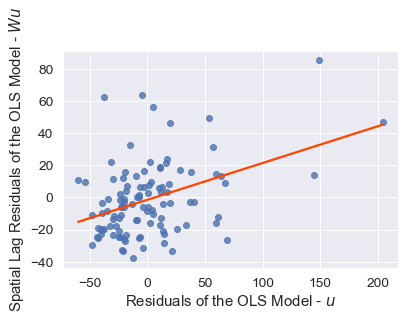

In [103]:
lag_residual = weights.lag_spatial(W_selected, M_OLS.u)
ax = sns.regplot(
    M_OLS.u.flatten(), 
    lag_residual.flatten(), 
    line_kws=dict(color='orangered'),
    ci=None
)
ax.set_xlabel('Residuals of the OLS Model - $u$')
ax.set_ylabel('Spatial Lag Residuals of the OLS Model - $W u$');

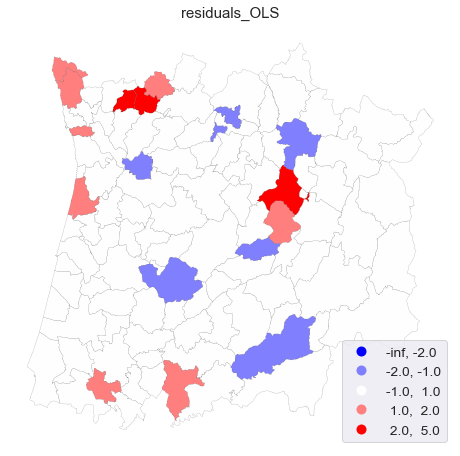

In [104]:
f, ax = plt.subplots(1, figsize=(8,12))
ax = df.plot(
    column='Z_Score_residuals_OLS',         
    scheme='StdMean',          
    cmap='bwr',                
    edgecolor='k',             
    linewidth=0.1,             
    legend=True,               
    legend_kwds={'fmt':'{:.1f}', 'loc' :'lower right'},
    ax = ax
)

ax.set_title('residuals_OLS')
ax.set_axis_off()

The municipalities where the model is least efficient are as follows:

In [105]:
c = 0
for freguesia in df[(df["Z_Score_residuals_OLS"] < -1) | (df["Z_Score_residuals_OLS"] > 1)].Freguesia:
    print(freguesia)
    c += 1

União das freguesias de Raiva, Pedorido e Paraíso
Esmoriz
Aldeia de São Francisco de Assis
Zambujal
Alvares
Forninhos
Manteigas (São Pedro)
Refontoura
União das freguesias de Lustosa e Barrosas (Santo Estêvão)
Frazão Arreigada
Ramalde
Estela
Árvore
Cidadelhe
Alvações do Corgo
Cujó
Real
Riodades
Faia
Ferreirós do Dão


In [106]:
c

20

Elhorst 2010 decision tree

![models](models.jpg)

#### 1. SAR – Spatial autoregressive model

$$
\mathbf{Y} = \rho W\mathbf{Y} + \beta\mathbf{X}  + \mu
$$

In [107]:
M_SAR = spreg.ML_Lag(
    Dep_Var.values, # Dependent variable
    Ind_Var.values, # Independent variable
    name_y = 'COVID_confirmados_10mil_hab', # Dependent variable name 
    name_x = Ind_var_columns, #Independent variable name
    w = W_selected)

print(M_SAR.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :COVID_confirmados_10mil_hab                Number of Observations:         106
Mean dependent var  :     59.2629                Number of Variables   :           6
S.D. dependent var  :     52.2712                Degrees of Freedom    :         100
Pseudo R-squared    :      0.5074
Spatial Pseudo R-squared:  0.4277
Sigma-square ML     :    1338.359                Log likelihood        :    -534.851
S.E of regression   :      36.584                Akaike info criterion :    1081.703
                                                 Schwarz criterion     :    1097.683

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
--------------

#### 2. SEM - Spatial error model

$$
Y = \beta\mathbf{X} + \lambda W\mathbf{\epsilon} + \mu
$$


In [108]:
M_SEM = spreg.ML_Error(
    Dep_Var.values, # Dependent variable
    Ind_Var.values, # Independent variable
    name_y = 'COVID_confirmados_10mil_hab', # Dependent variable name 
    name_x = Ind_var_columns, #Independent variable name
    w = W_selected)

print(M_SEM.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :COVID_confirmados_10mil_hab                Number of Observations:         106
Mean dependent var  :     59.2629                Number of Variables   :           5
S.D. dependent var  :     52.2712                Degrees of Freedom    :         101
Pseudo R-squared    :      0.3922
Sigma-square ML     :    1392.272                Log likelihood        :    -536.978
S.E of regression   :      37.313                Akaike info criterion :    1083.955
                                                 Schwarz criterion     :    1097.273

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
--------------------------------------------

#### 3. SAC - Spatial autoregressive combined model

$$
Y = \rho W\mathbf{Y} + \beta\mathbf{X} + \lambda W\mathbf{\epsilon} + \mu
$$


In [109]:
M_SAC = spreg.GM_Combo(
    Dep_Var.values, # Dependent variable
    Ind_Var.values, # Independent variable
    name_y = 'COVID_confirmados_10mil_hab', # Dependent variable name 
    name_x = Ind_var_columns, #Independent variable name
    w = W_selected)

print(M_SAC.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED TWO STAGE LEAST SQUARES
-------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :COVID_confirmados_10mil_hab                Number of Observations:         106
Mean dependent var  :     59.2629                Number of Variables   :           6
S.D. dependent var  :     52.2712                Degrees of Freedom    :         100
Pseudo R-squared    :      0.5200
Spatial Pseudo R-squared:  0.4366

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      42.0228856      49.8230464       0.8434427       0.3989809
  aloj_habitual_perc     122.7220087      53.0090360       2.3151149       0.0206066
      terciario_perc  

#### 4. SLX - Spatial Lag of X model

$$
Y = \beta\mathbf{X} +\theta W\mathbf{X} + \mu
$$

modelo OLS mas introduz as variáveis X_i espacialmente desfasadas

In [110]:
M_SLX = spreg.OLS(
    Dep_Var.values, # Dependent variable
    Ind_Var_lag.values, # Independent variable
    name_y = 'COVID_confirmados_10mil_hab', # Dependent variable name 
    name_x = Ind_Var_lag_columns, #Independent variable name
    w = W_selected)

print(M_SLX.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :COVID_confirmados_10mil_hab                Number of Observations:         106
Mean dependent var  :     59.2629                Number of Variables   :           9
S.D. dependent var  :     52.2712                Degrees of Freedom    :          97
R-squared           :      0.4314
Adjusted R-squared  :      0.3845
Sum squared residual:  163127.673                F-statistic           :      9.1990
Sigma-square        :    1681.729                Prob(F-statistic)     :   2.397e-09
S.E. of regression  :      41.009                Log likelihood        :    -539.367
Sigma-square ML     :    1538.940                Akaike info criterion :    1096.733
S.E of regression ML:     39.2293                Schwarz criterion     :    1120.704

--------------------------------------------------------------

#### 5. SDM - Spatial Durbin model

$$
Y = \rho W\mathbf{Y} + \beta\mathbf{X} +\theta W\mathbf{X} + \mu
$$

Using the non-spatial linear model trained above, we can verify that we can reject the null hypothesis that $\rho$ equals 0 and accept the null that $\lambda$ equals 0. That said, we proceed to the left-hand side of the decision tree and are then required to estimate the SDM and SAR model

In [111]:
M_SDM = spreg.ML_Lag(
    Dep_Var.values, # Dependent variable
    Ind_Var_lag.values, # Independent variable
    name_y = 'COVID_confirmados_10mil_hab', # Dependent variable name 
    name_x = Ind_Var_lag_columns, #Independent variable name
    w = W_selected)

print(M_SDM.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :COVID_confirmados_10mil_hab                Number of Observations:         106
Mean dependent var  :     59.2629                Number of Variables   :          10
S.D. dependent var  :     52.2712                Degrees of Freedom    :          96
Pseudo R-squared    :      0.5112
Spatial Pseudo R-squared:  0.4376
Sigma-square ML     :    1326.471                Log likelihood        :    -533.973
S.E of regression   :      36.421                Akaike info criterion :    1087.946
                                                 Schwarz criterion     :    1114.580

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
--------------

#### 6. SDEM - Spatial Durbin Error model

$$
Y = \beta\mathbf{X} +\theta W\mathbf{X} + \lambda W\mathbf{\epsilon} + \mu
$$

In [112]:
M_SDEM = spreg.ML_Error(
    Dep_Var.values, # Dependent variable
    Ind_Var_lag.values, # Independent variable
    name_y = 'COVID_confirmados_10mil_hab', # Dependent variable name 
    name_x = Ind_Var_lag_columns, #Independent variable name
    w = W_selected)

print(M_SDEM.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :COVID_confirmados_10mil_hab                Number of Observations:         106
Mean dependent var  :     59.2629                Number of Variables   :           9
S.D. dependent var  :     52.2712                Degrees of Freedom    :          97
Pseudo R-squared    :      0.4302
Sigma-square ML     :    1336.385                Log likelihood        :    -534.303
S.E of regression   :      36.557                Akaike info criterion :    1086.606
                                                 Schwarz criterion     :    1110.577

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
--------------------------------------------

#### 7. GNS – General nesting spatial model

$$
Y = \rho W\mathbf{Y} + \beta\mathbf{X} +\theta W\mathbf{X} + \lambda W\mathbf{\epsilon} + \mu
$$

In [113]:
M_GNS = spreg.GM_Combo(
    Dep_Var.values, # Dependent variable
    Ind_Var_lag.values, # Independent variable
    name_y = 'COVID_confirmados_10mil_hab', # Dependent variable name 
    name_x = Ind_Var_lag_columns, #Independent variable name
    w = W_selected)

print(M_GNS.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED TWO STAGE LEAST SQUARES
-------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :COVID_confirmados_10mil_hab                Number of Observations:         106
Mean dependent var  :     59.2629                Number of Variables   :          10
S.D. dependent var  :     52.2712                Degrees of Freedom    :          96
Pseudo R-squared    :      0.5300
Spatial Pseudo R-squared:  0.4542

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT      30.3319152      64.2516497       0.4720799       0.6368697
  aloj_habitual_perc     126.3966144      68.8136847       1.8367947       0.0662402
      terciario_perc  

In [114]:
spreg.diagnostics.likratiotest(M_SAR, M_SDM)

{'likr': 1.7566458344026614, 'df': 1, 'p-value': 0.1850434349876204}

### Synthesis

As mentioned, by the robust LM test we reject the null hypothesis of $\rho = 0$ and accept the null hypothesis of $\lambda = 0$, which makes us move to the left side of the tree. Through the SAR model we can confirm that the lagged variable is highly significant, which proves that the $\rho$ coefficient is necessary.  By comparing the SAR and SDM models with the likelihood ratio test we accept the null hypothesis that $\theta$ equals 0. Therefore, following the decision tree, the best model would be the SAR

In [115]:
mses = pd.Series({'OLS': mse(df["COVID_confirmados_10mil_hab"], M_OLS.predy), 
                  'M-SAR': mse(df["COVID_confirmados_10mil_hab"], M_SAR.predy), 
                  'M_SEM': mse(df["COVID_confirmados_10mil_hab"], M_SEM.predy),
                  'M_SAC': mse(df["COVID_confirmados_10mil_hab"], M_SAC.predy),
                  'M_SLX': mse(df["COVID_confirmados_10mil_hab"], M_SLX.predy),
                  'M_SDM': mse(df["COVID_confirmados_10mil_hab"], M_SDM.predy),
                  'M_SDEM': mse(df["COVID_confirmados_10mil_hab"], M_SDEM.predy),
                  'M_GNS': mse(df["COVID_confirmados_10mil_hab"], M_GNS.predy)
                    })
mses.sort_values()

M_GNS     1272.185042
M_SAC     1300.761952
M_SDM     1326.470506
M-SAR     1338.358864
M_SLX     1538.940313
M_SDEM    1542.532053
OLS       1635.701619
M_SEM     1663.466893
dtype: float64

What we can see from the mse values is that SDM would be the third best model and not the best. The best model would be GNS followed by the model that results from the combination of SAR and SEM, SAC. This result does not make much sense since the null hypothesis that $\lambda$ equals zero was accepted

We can see that by introducing spatial lag the models improve because the nonspatial linear model is one of the worst models

Comparison of results at the national level

In [116]:
mses_national = pd.Series({'OLS': 1595.197853, 
                  'M-SAR': 1044.301028, 
                  'M_SEM': 1799.956439,
                  'M_SAC': 998.984941,
                  'M_SLX': 1437.329477,
                  'M_SDM': 1038.930250,
                  'M_SDEM': 1452.921895,
                  'M_GNS': 1154.426975
                    })

In [117]:
mses_comparison_df = pd.DataFrame(dict(s1 = mses, s2 = mses_national))
mses_comparison_df.rename(columns={"s1":"NUTS III surrounding Viseu", "s2" : "National"}, inplace=True)
mses_comparison_df

,NUTS III envolvente a Viseu,Nacional
OLS,1635.701619,1595.197853
M-SAR,1338.358864,1044.301028
M_SEM,1663.466893,1799.956439
M_SAC,1300.761952,998.984941
M_SLX,1538.940313,1437.329477
M_SDM,1326.470506,1038.930250
M_SDEM,1542.532053,1452.921895
M_GNS,1272.185042,1154.426975


we can verify that at the national level the best model would be the SAC model while for the NUTS III regions surrounding Viseu it would be the GNS. Additionally, the national mse values, in general, are lower than those obtained, which shows that the models at the national level are better. 